## Environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from umap import UMAP
import warnings
import random

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

## Data

In [ ]:
# Load data
data = pd.read_csv("/content/breast-cancer.csv")

In [ ]:
# View structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
data['diagnosis'].value_counts()

,count
diagnosis,
B,357
M,212


## Clean and Split

In [ ]:
# Rename columns
data.rename(columns={'concave points_mean': 'concave_points_mean',
                     'concave points_se': 'concave_points_se',
                     'concave points_worst': 'concave_points_worst'}, inplace=True)

# Convert diagnosis to binary
data['diagnosis'] = data['diagnosis'].astype('category').map({'M': 1, 'B': 0})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       569 non-null    int64   
 1   diagnosis                569 non-null    category
 2   radius_mean              569 non-null    float64 
 3   texture_mean             569 non-null    float64 
 4   perimeter_mean           569 non-null    float64 
 5   area_mean                569 non-null    float64 
 6   smoothness_mean          569 non-null    float64 
 7   compactness_mean         569 non-null    float64 
 8   concavity_mean           569 non-null    float64 
 9   concave_points_mean      569 non-null    float64 
 10  symmetry_mean            569 non-null    float64 
 11  fractal_dimension_mean   569 non-null    float64 
 12  radius_se                569 non-null    float64 
 13  texture_se               569 non-null    float64 
 14  perimeter_

In [ ]:
# Train/test split with stratification
# Ignore id variable
X = data.drop(columns=['diagnosis', 'id'])
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)

In [ ]:
print(f"Training set shape: X {X_train.shape}, y {y_train.shape}")
print(f"Test set shape: X {X_test.shape}, y {y_test.shape}")

Training set shape: X (398, 30), y (398,)
Test set shape: X (171, 30), y (171,)


## Preprocessing Pipeline

In [ ]:
# Define pipeline
# Use imblearn version Pipeline as BorderlineSMOTE() is not compatible with sklearn version
# https://stackoverflow.com/questions/72749144/scikit-learn-pipeline-with-smote
pipeline = Pipeline([
    # Normalization
    ('scaler', StandardScaler()),

    # Upsampling
    ('smote', BorderlineSMOTE(random_state=SEED)),

    # Dimensional reduction
    ('umap', UMAP(random_state=SEED)),

    # SVM_rbf
    ('classifier', SVC(kernel='rbf', probability=True))
])

pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', BorderlineSMOTE(random_state=1234)),
                ('umap', UMAP(random_state=1234)),
                ('classifier', SVC(probability=True))])

## Cross-Validation

In [ ]:
# Define hyperparameter space
param_grid = {
    'umap__n_components': [5, 10, 15],
    'classifier__C': [0.01, 0.02, 0.05],
    'classifier__gamma': [0.01, 0.02, 0.05]
}

In [ ]:
# 10-fold CV, tried both GridSearchCV and RandomizedSearchCV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc')
# search = RandomizedSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_iter=3, random_state=SEED)

In [ ]:
# Train model
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote',
                                        BorderlineSMOTE(random_state=1234)),
                                       ('umap', UMAP(random_state=1234)),
                                       ('classifier', SVC(probability=True))]),
             param_grid={'classifier__C': [0.01, 0.02, 0.05],
                         'classifier__gamma': [0.01, 0.02, 0.05],
                         'umap__n_components': [5, 10, 15]},
             scoring='roc_auc')

In [ ]:
print("Best Parameters:", search.best_params_)

Best Parameters: {'classifier__C': 0.01, 'classifier__gamma': 0.05, 'umap__n_components': 15}


## Preidction

In [ ]:
# Predict and evaluate
y_pred = search.predict(X_test)

In [ ]:
# Metrics
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       107
           1       0.83      0.98      0.90        64

    accuracy                           0.92       171
   macro avg       0.91      0.93      0.92       171
weighted avg       0.93      0.92      0.92       171



## Confusion Matrix

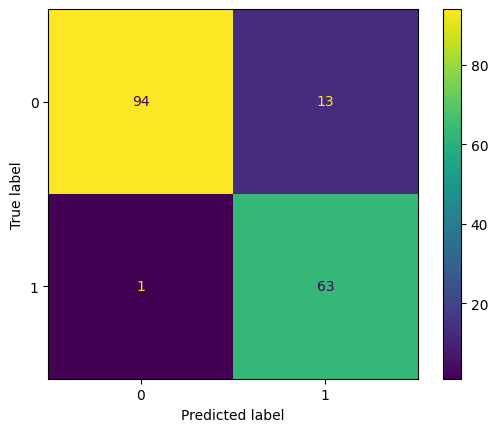

In [ ]:
# Confusion Matrix
labels = search.best_estimator_.classes_

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()